In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr
import scipy.stats as stats


#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well


#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, time_series_henColumn_tsRow
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)

dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_MVTCLUSTER = os.path.join(path_extracted_data_visual_adap,'MVTCLUSTERING')
path_extracted_data_visual_adap_MVTCLUSTER_tsvisual = os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'tsvisual')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_MVTCLUSTER_tsvisual):
    os.makedirs(path_extracted_data_visual_adap_MVTCLUSTER_tsvisual)
print(id_run)

change the configuration file if not done yet!
correctlightschedule_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [5]:
#selected hens
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_selected_hens.pkl'), 'rb'))
len(li_selected_hens)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


132

In [6]:
#daily variables (one row per (henID, date))
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: int((x-119)/7)+1)
#df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)

#filter by dates
df_daily = df_daily[df_daily['level']<=max_date_adaptability] 
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]

#filter the selected hens
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)] 
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27214, 199)
(6772, 199)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL,weeks_in_laying_barn
0,hen_1,2020-09-30,0.0,18886.0,3488.0,518.0,5908.0,28800.0,"[0.0, 18886.0, 3488.0, 518.0, 5908.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [7]:
#cleaned data of the tracking system movements
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', 
                 parse_dates=['Timestamp', 'date'], dayfirst=True) 
df = df[df['Timestamp']<=max_date_adaptability+dt.timedelta(days=2)] #add two days to have the next observations as well when doing the 1sec ts
df['hour'] = df['Timestamp'].map(lambda x: x.hour)
df['time'] = df['Timestamp'].map(lambda x: dt.datetime.time(x-dt.timedelta(seconds=x.second)))
df = df[df['HenID'].isin(li_selected_hens)] 
df.drop('duration', axis=1, inplace=True)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(301289, 17)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,hour,time
0,hen_71,pen12,10 - 12,3_Zone,1.0,2020-09-29 09:07:00,2020-09-29,2020-09-29 09:08:26.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:07:00
1,hen_7,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:08:12,2020-09-29,2020-09-29 09:12:16.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:08:00
2,hen_10,pen11,10 - 12,3_Zone,1.0,2020-09-29 09:19:19,2020-09-29,2020-09-29 09:20:27.000,NaN,NaN,3_Zone,NaN,NaN,False,False,9,09:19:00


In [8]:
#focal birds info (one row per bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'],
                     dayfirst=True) 
df_FB = df_FB[df_FB['HenID'].isin(li_selected_hens)]
print(df_FB.shape)
df_FB.head(3)

(132, 11)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,1787.8,1800.9,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,1628.4,1602.1,OFH
3,hen_101,5,MEXP,3.0,2020-06-10,1082.0,66.0,1625.7,1751.1,1723.4,OFH


In [9]:
#download the two groups
li_gr1 = pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_hen_NoMvt_3days.pkl'), 'rb'))
li_gr2 = pickle.load(open(os.path.join(path_extracted_data_visual_adap,'li_hen_Mvt_3days.pkl'), 'rb'))
dico_gr_name = {'group1':'NMVT' , 'group2':'MVT'}
print(len(li_gr1), len(li_gr2))

48 84


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dico_gr_name = {'group1':'NMVT' , 'group2':'MVT'}
li_gr1 = li_selected_hens[0:60]
li_gr2 = li_selected_hens[60:]

# Basic plot about those two groups

In [10]:
df_daily['EarlyGroup'] = df_daily['HenID'].map(lambda x: dico_gr_name['group1'] if x in li_gr1 else np.nan)
df_daily['EarlyGroup'] = df_daily.apply(lambda x: dico_gr_name['group2'] if x['HenID'] in li_gr2 else x['EarlyGroup'], axis=1)

df_FB['EarlyGroup'] = df_FB['HenID'].map(lambda x: dico_gr_name['group1'] if x in li_gr1 else np.nan)
df_FB['EarlyGroup'] = df_FB.apply(lambda x: dico_gr_name['group2'] if x['HenID'] in li_gr2 else x['EarlyGroup'], axis=1)
df_FB['EarlyGroup'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MVT     84
NMVT    48
Name: EarlyGroup, dtype: int64

In [24]:
#we dont normlaize it by pen or anything as we still wan tt se the true nbr of animals per pen/treatment/class
fig = dxp.count('PenID', data=df_FB, split='EarlyGroup')
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerPen.png'))
fig = dxp.count('R-Pen', data=df_FB, split='EarlyGroup', split_order='desc') 
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerRPen.png'))
fig = dxp.count('CLASS', data=df_FB, split='EarlyGroup') 
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerClass.png'))
fig = dxp.count('Treatment', data=df_FB, split='EarlyGroup') 
fig.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'AnimalPerTreatment.png'))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,EarlyGroup,variable,value,date
164,hen_137,MVT,10-12 juin weight,65.5,2020-06-11
168,hen_140,MVT,10-12 juin weight,70.2,2020-06-11


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


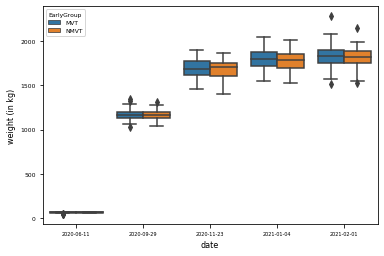

In [27]:
li_weight = [i for i in df_FB.columns if 'weight' in i]
dico_name_date = {'29-09 weight':dt.date(2020,9,29),
                  '10-12 juin weight':dt.date(2020,6,11),
                  'weight 23-11-2020':dt.date(2020,11,23),
                  'weight 04-01-2021':dt.date(2021,1,4),
                  'weight 01-02-21':dt.date(2021,2,1)}
df_weight = pd.melt(df_FB, id_vars=['HenID','EarlyGroup'], value_vars=li_weight)
df_weight['date'] = df_weight['variable'].map(lambda x: dico_name_date[x])
df_weight.sort_values(['date'], inplace=True)
display(df_weight.head(2))
ax = sns.boxplot(data=df_weight, x='date', y='value', hue='EarlyGroup')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 5)
#ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 5)
plt.ylabel('weight (in kg)',fontsize=8);
plt.xlabel('date',fontsize=8);
plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,'Weight.png'), bbox_inches='tight')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(281178, 4)


,DOA,HenID,variable,duration_of_stay
0,150,hen_1,1_Zone,190
1,150,hen_1,1_Zone,379
2,151,hen_1,1_Zone,61


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 80.27it/s]

(15, 6)


,time_range,Winter garden,Litter,Lower perch,Nestbox,Top floor
0,0h -1h,13666,80120,98188,51379,24924
1,1h -2h,80,2935,520,740,4123
2,2h -3h,4,297,27,42,1621


,Winter garden,Litter,Lower perch,Nestbox,Top floor
time_range,,,,,
0h -1h,5.093989,29.864655,36.599485,19.151474,9.290398
1h -2h,0.952608,34.948797,6.191950,8.811622,49.095023
2h -3h,0.200904,14.917127,1.356102,2.109493,81.416374


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


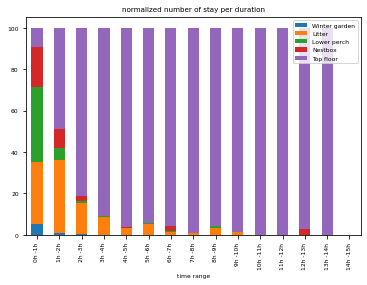

In [43]:
df_dur = df_daily[['dico_zone_sortedduration','HenID','DOA']].copy()
df_dur = df_dur[~df_dur['dico_zone_sortedduration'].isnull()]
df_dur['dico_zone_sortedduration'] = df_dur['dico_zone_sortedduration'].map(lambda x: eval(x))
df_dur = pd.concat([df_dur.drop(['dico_zone_sortedduration'], axis=1), df_dur['dico_zone_sortedduration'].apply(pd.Series)], 
                   axis=1)
df_dur = pd.melt(df_dur, id_vars=['HenID', 'DOA'], value_vars=['1_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zone'])
#remove all the stay that are=np.nan i.e.e not existing in this zone o that day by that hen
df_dur = df_dur[~df_dur['value'].isnull()]
df_dur = df_dur.set_index(['DOA','HenID','variable']).value.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(int).reset_index()
df_dur.rename(columns={0:'duration_of_stay'}, inplace=True)
#TODO: add weight and then plot!
print(df_dur.shape)
display(df_dur.head(3))
li_df = []
for h in tqdm.tqdm(range(0,15)):
    df_ = df_dur[(df_dur['duration_of_stay']>=(h*60*60))&(df_dur['duration_of_stay']<((h+1)*60*60))].copy()
    dico_ = {'time_range':str(h)+'h -'+str(h+1)+'h', 
             'Winter garden': df_[df_['variable']=='1_Zone'].shape[0], 
             'Litter': df_[df_['variable']=='2_Zone'].shape[0], 
             'Lower perch': df_[df_['variable']=='3_Zone'].shape[0], 
             'Nestbox': df_[df_['variable']=='4_Zone'].shape[0], 
             'Top floor': df_[df_['variable']=='5_Zone'].shape[0]}
    li_df.append(dico_)
df_plt = pd.DataFrame(li_df)
print(df_plt.shape)
display(df_plt.head(3))
df_plt = df_plt.set_index('time_range')
df_plt.fillna(0,inplace=True)
df_plot_normalized = df_plt.div(df_plt.sum(axis=1)/100, axis=0)
display(df_plot_normalized.head(3))
df_plot_normalized.plot(kind='bar',stacked=True);
plt.xlabel('time range')
plt.title('normalized number of stay per duration')
plt.savefig(os.path.join(path_extracted_data_visual_adap,'Duration_of_stays_perZone.png'), bbox_inches='tight')
plt.show();

# Difference in movement patterns?

In [ ]:
df_daily

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,down_missingZone_mvtPerc,16.666667
1,MVT,hen_1,2020-10-01,down_missingZone_mvtPerc,16.666667
2,MVT,hen_1,2020-10-02,down_missingZone_mvtPerc,50.000000


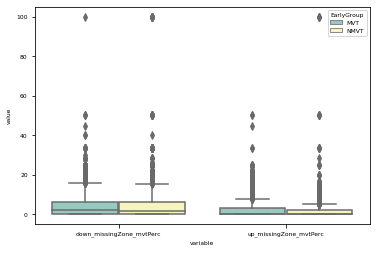

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,max_duration,18886.0
1,MVT,hen_1,2020-10-01,max_duration,15030.0
2,MVT,hen_1,2020-10-02,max_duration,21371.0


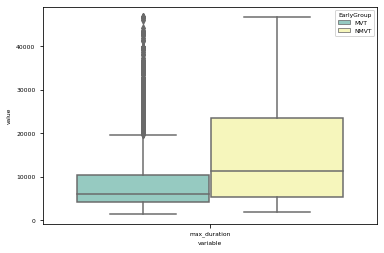

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,vertical_travel_distance,9.0
1,MVT,hen_1,2020-10-01,vertical_travel_distance,18.0
2,MVT,hen_1,2020-10-02,vertical_travel_distance,4.0


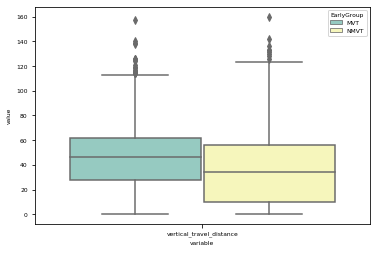

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,in_WG_15mnAfterOpening,0.0
1,MVT,hen_1,2020-10-01,in_WG_15mnAfterOpening,0.0
2,MVT,hen_1,2020-10-02,in_WG_15mnAfterOpening,0.0


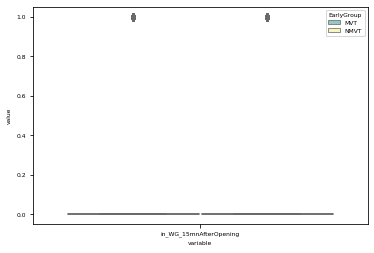

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,Max_duration_WG,0.0
1,MVT,hen_1,2020-10-01,Max_duration_WG,0.0
2,MVT,hen_1,2020-10-02,Max_duration_WG,0.0


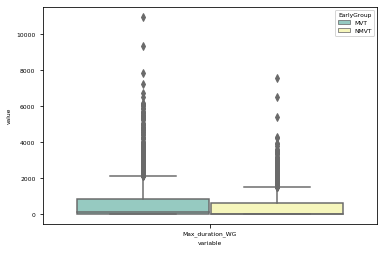

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,nbr_stays_1_Zone,0.0
1,MVT,hen_1,2020-10-01,nbr_stays_1_Zone,0.0
2,MVT,hen_1,2020-10-02,nbr_stays_1_Zone,0.0


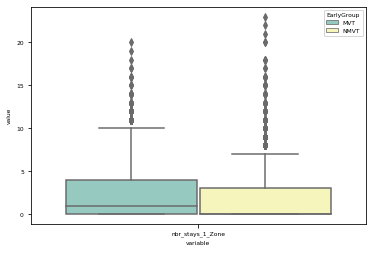

,EarlyGroup,HenID,level,variable,value
0,MVT,hen_1,2020-09-30,perc_duration_1_Zone,0.0
1,MVT,hen_1,2020-10-01,perc_duration_1_Zone,0.0
2,MVT,hen_1,2020-10-02,perc_duration_1_Zone,0.0


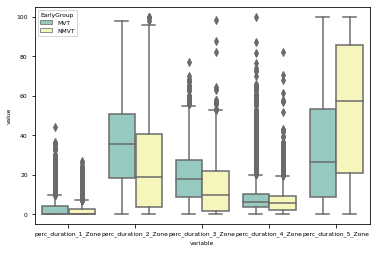

In [26]:
#### plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
li_activity = [['down_missingZone_mvtPerc', 'up_missingZone_mvtPerc'], 'max_duration','vertical_travel_distance',
               'in_WG_15mnAfterOpening', 'Max_duration_WG','nbr_stays_1_Zone',
              ['perc_duration_1_Zone', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 
               'perc_duration_5_Zone']]
name_ = 1
for x in li_activity:
    df_plt = pd.melt(df_daily, id_vars=['EarlyGroup','HenID','level'], value_vars=x).reset_index(drop=True)
    display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="EarlyGroup",data=df_plt, palette="Set3")
    name_ = name_+1
    plt.savefig(os.path.join(path_extracted_data_visual_adap_MVTCLUSTER,str(name_)+'.png'), bbox_inches='tight')
    plt.show();

# Compute differences

In [45]:
print(df_daily.shape)
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)]
print(df_daily.shape)
print(df.shape)
df = df[df['HenID'].isin(li_selected_hens)]
print(df.shape)

(6772, 200)
(6772, 200)
(301289, 17)
(301289, 17)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
#intersection of two list
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
lst1 = [15, 9, 10, 56, 23, 78, 5, 4, 9] 
lst2 = [9, 4, 5, 36, 47, 26, 10, 45, 87] 
print(intersection(lst1, lst2)) 

[9, 10, 4, 5]


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#for efficiency purpose let's compute the bined time series first
#note that we will have more entries than needed, as the distrubances days are not removed in the raw-cleaned movements
#dataframe.
dico_bin_zone_level_h = {}   
dmin = dt.datetime(2020,9,30)
dmax = dt.datetime(2020,11,22)

print('computing time series...')
df_ts = time_series_henColumn_tsRow(df[(df['date']<=dmax)&(df['date']>=dmin)&(df['HenID'].isin(list(li_gr1)+list(li_gr2)))], 
                                    config, col_ts='Zone', ts_with_all_hen_value=False, save=False,  hen_time_series=False)

print('Extract binary ts of MLP...')
for nbr_binmn in tqdm.tqdm(li_binmn):
    
    #update results
    dico_bin_zone_level_h[nbr_binmn] = {}

    #reduce to the interval we want
    mi = min(df_ts['Timestamp'].tolist())
    ma = max(df_ts['Timestamp'].tolist())
    #extend the end to the end of the day in case it case the last day available fo the chicken
    Daterange = pd.date_range(start = mi, end = ma, freq = str(nbr_binmn)+'MIN')    
    df_date = pd.DataFrame({str(nbr_binmn)+'mn_timestamp':Daterange})
    new_timestamp = str(nbr_binmn)+'mn_timestamp'
    df_date[new_timestamp] = df_date[new_timestamp].map(lambda x: pd.to_datetime(x))
    df_ts_ = pd.merge_asof(df_ts, df_date, left_on=['Timestamp'], right_on=[new_timestamp], direction='forward')
    #groupby the interval that we want with the number of minutes in nestbox
    li_hen = [v for v in df_ts.columns if 'hen_' in v]
    for ZONE in df['Zone'].unique():

        #update results
        dico_bin_zone_level_h[nbr_binmn][ZONE] = {}

        df_zone_sim = df_ts_.groupby(new_timestamp)[li_hen].agg(lambda x: sum([i==ZONE for i in x])/60).reset_index()
        df_zone_sim['date'] = df_zone_sim[new_timestamp].map(lambda x: dt.datetime(x.year,x.month,x.day))

        #groupby date to have a list of zones per day (rows) for the hens (columns)
        df_zone_sim = df_zone_sim.groupby('date')[li_hen].agg(lambda x: list(x)).reset_index()
        #print(df_zone_sim.shape)
        #display(df_zone_sim.head(3))

        #melt to have one row per (day, hens) to avoid looping to create the dictionary
        df_zone_sim_ = pd.melt(df_zone_sim, id_vars=['date'], value_vars=li_hen)
        #variable column has the henIDs
        #print(df_zone_sim_.shape)
        #display(df_zone_sim_.head(3))
        for d, df__ in df_zone_sim_.groupby(['date']):
            #update results
            dico_bin_zone_level_h[nbr_binmn][ZONE][d] = dict(zip(df__['variable'].tolist(), df__['value'].tolist()))
#save dictionary
pickle.dump(dico_bin_zone_level_h, open(os.path.join(path_extracted_data_visual_adap, 
                                                 id_run+'dico_bin_zone_level_h_SAMEDAYS.pkl'), 'wb'), pickle.HIGHEST_PROTOCOL)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing time series...
in this time series there is 132 hens
The initial starting date in over all is: 2020-09-30 02:20:57, and the ending date will be: 2020-11-22 22:44:55
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 02:20:57, and the ending date will be: 2020-11-22 23:59:59


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Total running time: 1.59 mn
Extract binary ts of MLP...


In [ ]:
#compute the chi2-distance from any two normalized vector of durations per zone that are from consectives days and same pen
random.seed(rv)
li_df = []
li_zone = df['Zone'].unique()
df.sort_values(['Timestamp'], inplace=True)
li_date = set(df_daily__['level'].tolist())
tr1 = df_daily__['Treatment'].unique()[0]
tr1 = df_daily__['Treatment'].unique()[0]
for d1 in sorted(list(li_date)):
    doa = df_doa[df_doa['level']==d1]['DOA'].values[0]
    woa = df_doa[df_doa['level']==d1]['WOA'].values[0]
    li_hen_d1 = df_daily__[df_daily__['level']==d1]['HenID'].unique()
    #its a symmetric measure, so we only do each combination once
    for i,h1 in enumerate(li_hen_d1):

        #for each hen we want to compute its difference with a random bird from the same group AND with a random bird from the
        #other group
        
        #first exatract list of available hens that day from each group
        li_gr1 = intersection(li_hen_d1, li_gr1)
        li_gr2 = intersection(li_hen_d1, li_gr2)
        
        #remove the actual hen (h1)
        if h1 in li_gr1:
            li_gr1.remove(h1)
            gr1 = 'group1'
        elif h2 in li_gr2:
            li_gr2.remove(h1)
            gr1 = 'group2'
        else:
            print('ERROR: your hen has no group beonging:', h1)
            sys.exit()
        
        #then choose one hen from each group
        h2_gr1 = random.sample(li_gr1, 1)[0]
        h2_gr2 = random.sample(li_gr2, 1)[0]
        
        #finally compute the difference
        for h2,gr2 in zip([h2_gr1, h2_gr2],['group1','group2']):
            print(h2,gr2)
       
            ############ Overall aviary usage similarity across days
            l1 = df_daily__[(df_daily__['HenID']==h1)&(df_daily__['level']==d1)]['dur_values_normalized'].values[0]
            l2 = df_daily__[(df_daily__['HenID']==h2)&(df_daily__['level']==d1)]['dur_values_normalized'].values[0]

            dico_ = {'level':d1, 'level+1':d1, 'henID1':h1, 'henID2':h2, 
                     'dur_values_normalized_henID1':l1,'dur_values_normalized_henID2':l2,'grouph1':gr1,'grouph2':gr2,
                     'chi2distance':chi2_distance(l1,l2),'DOA':doa,'WOA':woa}

            ############# Specifics' zones usage similarity across days
            for nbr_binmn in li_binmn:
                for ZONE in li_zone:
                    dtw_value = np.nan
                    try:
                        l1 = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h1], dtype=np.double)
                        l2 = np.array(dico_bin_zone_level_h[nbr_binmn][ZONE][d1][h2], dtype=np.double)
                        #compute distance measure
                        #psi: #of start and end points of a sequence can be ignored if this would lead to a lower distance
                        dtw_value, paths = dtw.warping_paths(l1, l2, window=dico_window[nbr_binmn], psi=0, penalty=penalty) #, max_step=0
                    except Exception as e:
                        pass #dont do anything
                    dico_['DTW_'+str(nbr_binmn)+'_'+ZONE] = round(dtw_value,1)  
                    dico_['nbr_obs_l1_'+str(nbr_binmn)+'_'+ZONE] = len(l1)
                    dico_['nbr_obs_l2_'+str(nbr_binmn)+'_'+ZONE] = len(l2)
            li_df.append(dico_)

#turn inter and intra distances into a dataframe                
df_interintra = pd.DataFrame(li_df)
#df_interintra = df_interintra[~df_interintra['chi2distance'].isnull()]
df_interintra['is_same_group'] = df_interintra.apply(lambda x: x['grouph1']==x['grouph2'], axis=1)
df_interintra['Group'] = df_interintra.apply(lambda x: dico_gr_name[x['grouph1']] if x['grouph1']==x['grouph2'] else '', axis=1)
df_interintra = df_interintra.sort_values('DOA', ascending=True)
dico_name = {True: 'Intra group', False:'Inter group'}
df_interintra['type'] = df_interintra.apply(lambda x: dico_name[x['is_same_ind']]+' - '+x['Group'], axis=1)
display(df_interintra['type'].value_counts())
df_interintra['weeks_in_laying_barn'] = df_interintra['DOA'].map(lambda x: int((x-119)/7)+1)
df_interintra['DTW_15_all'] = df_interintra[['DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']].sum(axis=1)
df_interintra.to_csv(os.path.join(path_extracted_data_visual_adap ,id_run+str(rv)+'_df_interintra_SAMEDAY.csv'), sep=';', index=False)
print(df_interintra.shape)
display(df_interintra.head(3))

In [ ]:
li_dist = ['chi2distance', 'DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','DTW_15_all']
li_info = ['level','level+1','henID1','henID2', 'DOA','weeks_in_laying_barn']

In [ ]:
df_interintra.groupby(['level','type'])['level+1'].count().reset_index()

# Visualise the intra of both group

In [ ]:
#dont compare the variability as not same amount of hens in each boxplot. But you can comapre the mean
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = ['Intra','Inter' TODO]
    sns.boxplot(x="DOA", y=v, hue="type", data=df_interintra[df_interintra['type_']=='Intra'], 
                linewidth=0.8, fliersize=0.7, palette = {'Intra':'bisque', 'Inter':'tan'}, hue_order=hue_order);
    #plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_DOA.png'),
    #            dpi=300,format='png',bbox_inches='tight')

# Visualise inter & intra difference & variability

In [15]:
df_interintra['type_'] = df_interintra['type_'].map(lambda x: x.split('-')[0].strip())
df_interintra['type_'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Intra    15644
Inter     1452
Name: type_2gr_, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


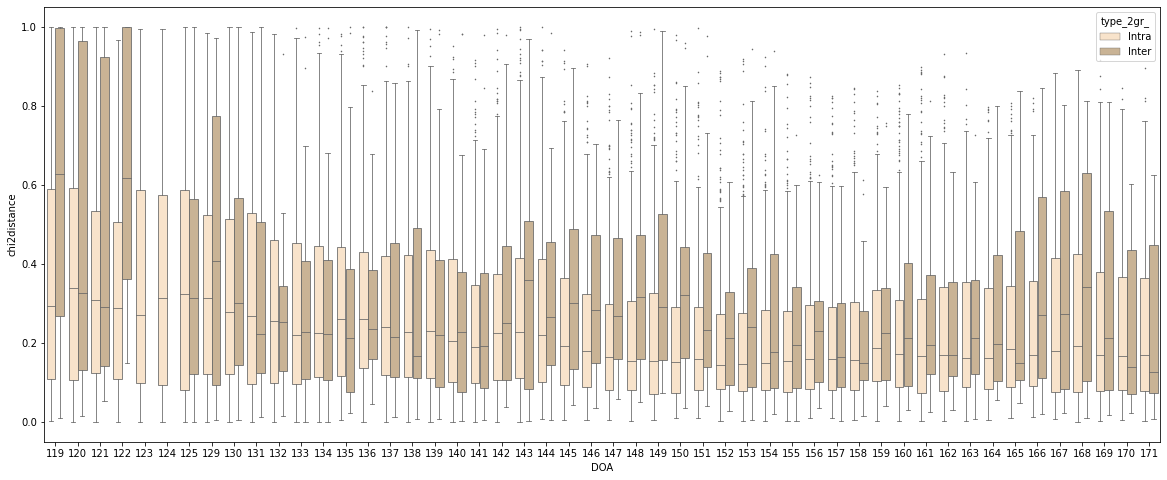

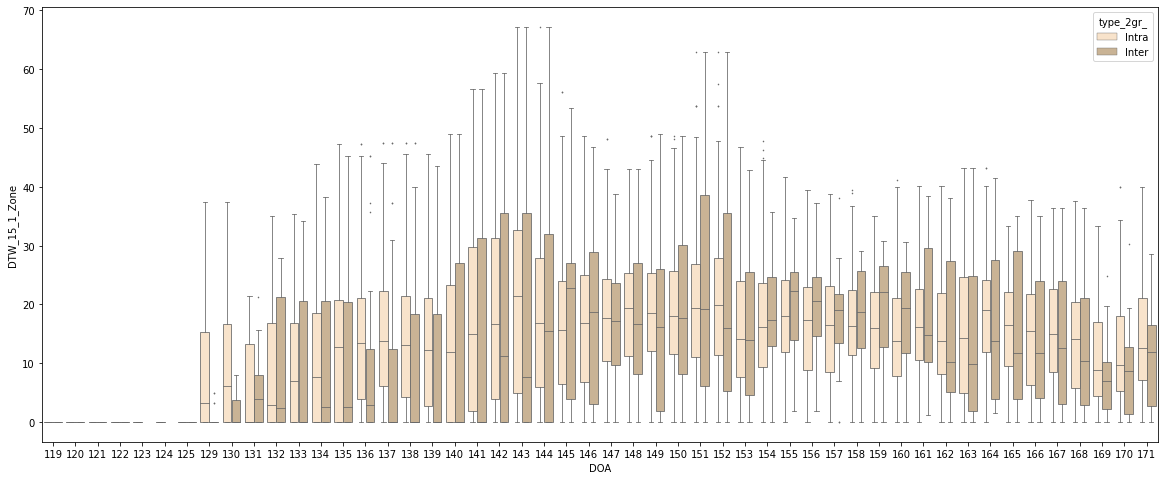

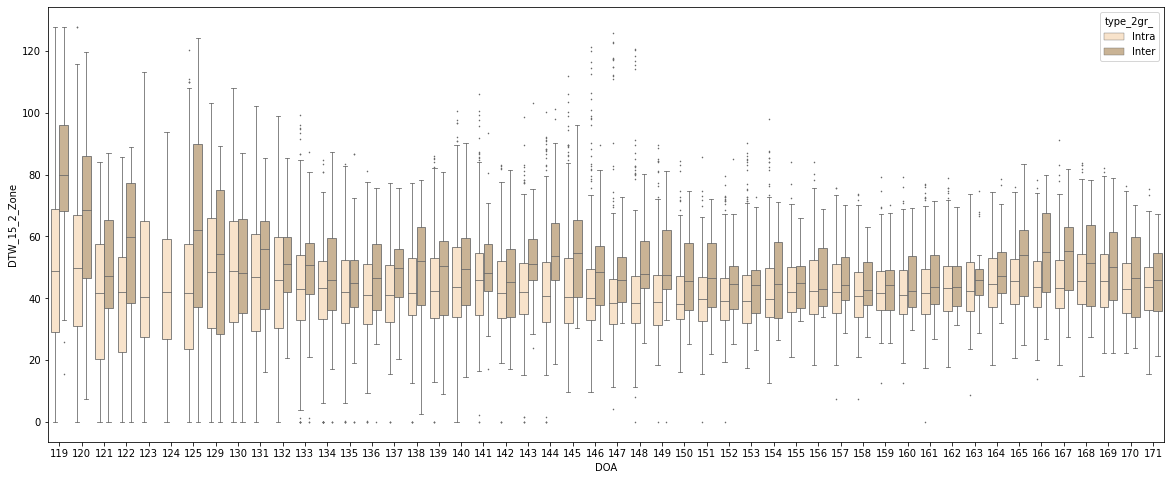

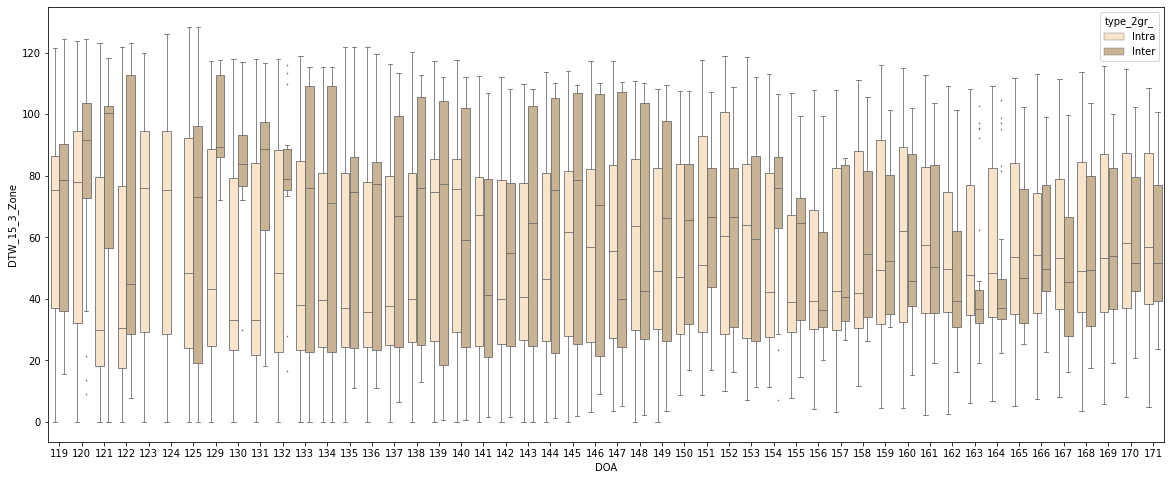

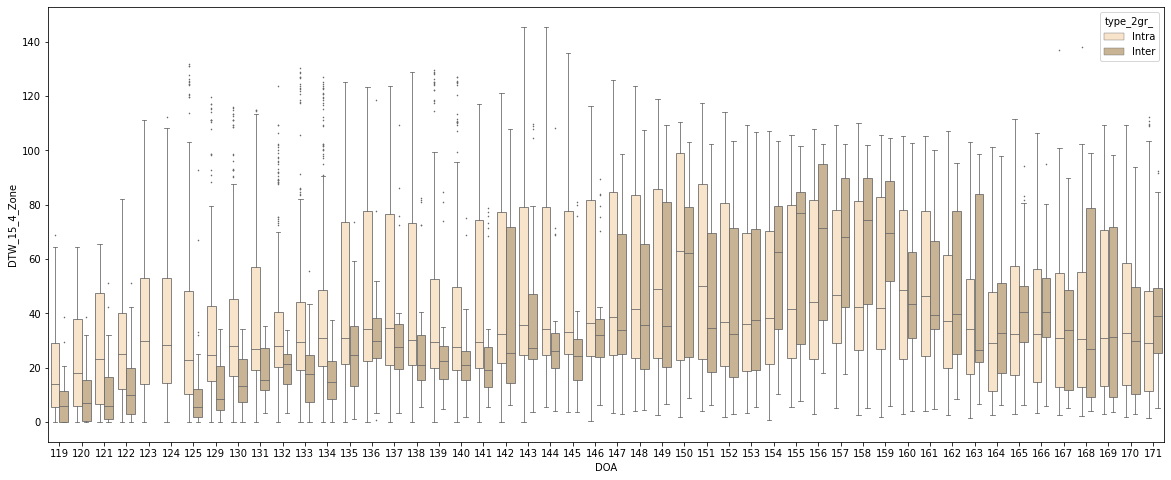

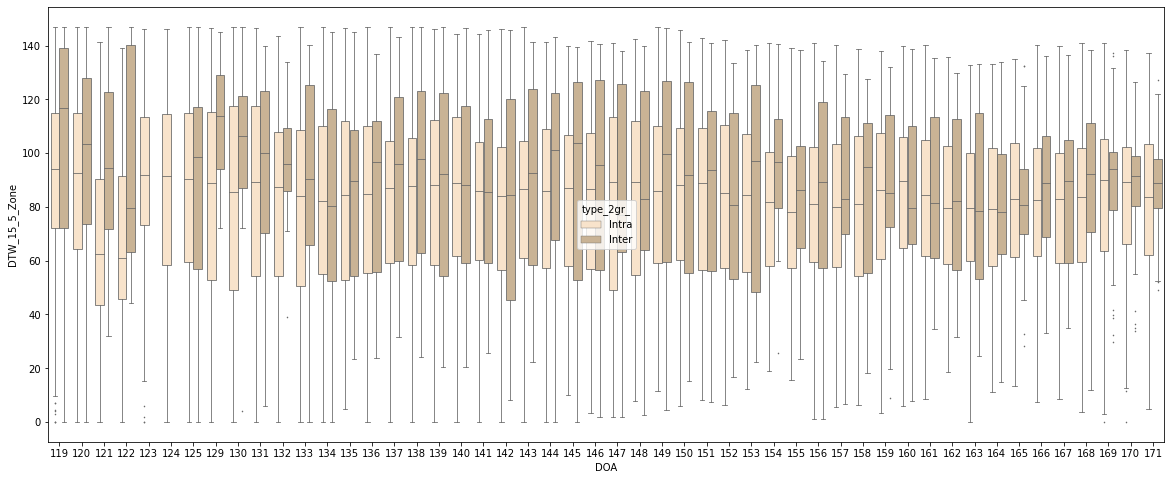

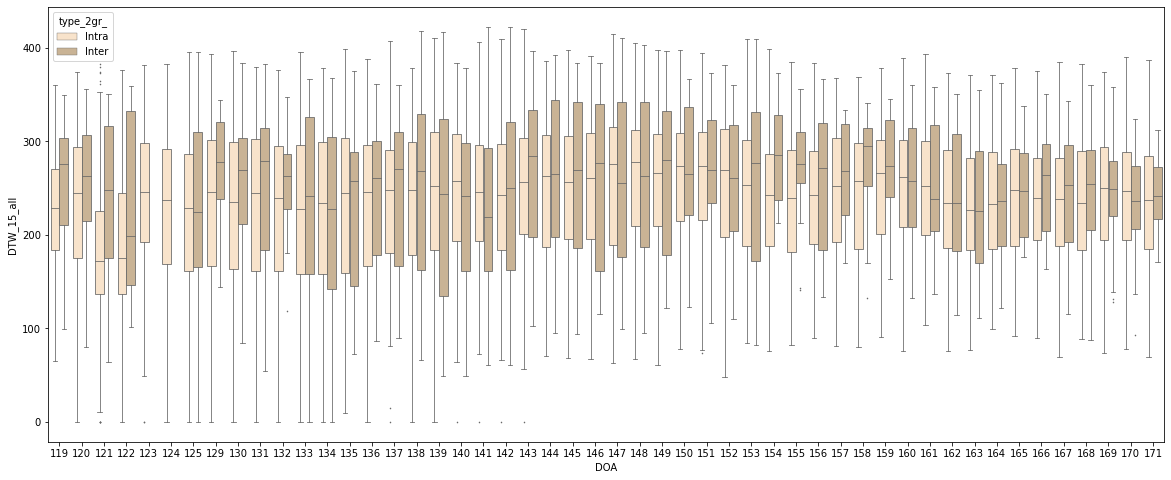

In [16]:
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = ['Intra','Inter']
    sns.boxplot(x="DOA", y=v, hue="type_", data=df_interintra, 
                linewidth=0.8, fliersize=0.7, palette = {'Intra':'bisque', 'Inter':'tan'}, hue_order=hue_order);
    #plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_DOA.png'),
    #            dpi=300,format='png',bbox_inches='tight')

In [ ]:
#dont compare the variability as not same amount of hens in each boxplot. But you can comapre the mean
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = ['Intra','Inter' TODO]
    sns.boxplot(x="DOA", y=v, hue="type", data=df_interintra[df_interintra['type_']=='Intra'], 
                linewidth=0.8, fliersize=0.7, palette = {'Intra':'bisque', 'Inter':'tan'}, hue_order=hue_order);
    #plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_DOA.png'),
    #            dpi=300,format='png',bbox_inches='tight')

# ANCOVA

# Groups of individuals consistenly more similar?

df_interintra_all['pair'] = df_interintra_all.apply(lambda x: '-'.join(sorted([x['henID1'], x['henID2']])), axis=1)
df_interintra_all['pair'].value_counts()

df_phenop = df_interintra_all[df_interintra_all['DOA']>119+30].groupby(['pair','is_same_ind'])['DTW_15_all'].agg(lambda x: list(x)).reset_index()
df_phenop['var'] = df_phenop['DTW_15_all'].map(lambda x: np.var(x))
df_phenop['avg'] = df_phenop['DTW_15_all'].map(lambda x: np.mean(x))
df_phenop['nbr_obs'] = df_phenop['DTW_15_all'].map(lambda x: len(x))
print(df_phenop.shape)
df_phenop.head(3)

sns.histplot(df_phenop, x="var", hue="is_same_ind", element="step", stat="density", common_norm=False)
plt.show()
sns.histplot(df_phenop, x="avg", hue="is_same_ind", element="step", stat="density", common_norm=False);

df_phenop['similar_birds'] = df_phenop.apply(lambda x: (x['var']<3000)&(x['avg']<180), axis=1)
df_phenop['similar_birds'].value_counts()

#keeping the intra difference allows to verify fo rthe technique as well :)
df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])].head(80)

### Basic hen ts visual

li_hens = list(set([i.split('-')[0] for i in df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])]['pair'].tolist()]+\
[i.split('-')[1] for i in df_phenop[(df_phenop['similar_birds'])&(~df_phenop['is_same_ind'])]['pair'].tolist()]))
print(len(li_hens))
rv = str(uuid.uuid1())
print(rv)
dico_ = {h:rv for h in li_hens}

#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,10,30)
dmax = dt.datetime(2020,11,23)
#define the cluster dic
ts_visual(df_=df, dmin=dmin, dmax=dmax, dico_h_cl=dico_, path_=path_extracted_data_visual_adap_MVTCLUSTER_tsvisual)